<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/GenerativeAdversarialNetwork/blob/main/GAN_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

libraries

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

utilities

In [2]:
def show_tensor_image(image_tensor, num_images= 25, size= (1, 28, 28)):
    image_tensor = (1 - image_tensor) / 2
    image_tensor = image_tensor.detach().cpu()
    image_grid = torchvision.utils.make_grid(image_tensor[: num_images], nrow= 5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

dataset

In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((.5, ), (.5, )),
])

In [4]:
batch_size= 128
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(".", transform= transforms, download= True),
    shuffle= True,
    batch_size= batch_size
)

100%|██████████| 9912422/9912422 [00:00<00:00, 131957898.75it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5664516.90it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69151998.77it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5795719.13it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



generator network

In [5]:
class Generator(torch.nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = torch.nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return torch.nn.Sequential(
                torch.nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                torch.nn.BatchNorm2d(output_channels),
                torch.nn.ReLU(inplace= True),
            )
        else: # Final Layer
            return torch.nn.Sequential(
                torch.nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                torch.nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

discriminator network

In [7]:
class Discriminator(torch.nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = torch.nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                torch.nn.BatchNorm2d(output_channels),
                torch.nn.LeakyReLU(.2, inplace= True)
            )
        else: # Final Layer
            return torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

defining loss and hyper parameters

In [8]:
criterion = torch.nn.BCEWithLogitsLoss()
z_dim = 64
beta_1 = 0.5 
beta_2 = 0.999
lr = 0.0002
device = 'cuda' if torch.cuda.is_available() else 'cpu'

initializing models for training

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

train process

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0, Generator loss: 0.8127, discriminator loss:  0.6441


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Generator loss: 0.7899, discriminator loss:  0.6583


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, Generator loss: 0.7823, discriminator loss:  0.6635


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, Generator loss: 0.7733, discriminator loss:  0.6731


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, Generator loss: 0.7574, discriminator loss:  0.6810


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, Generator loss: 0.7530, discriminator loss:  0.6817


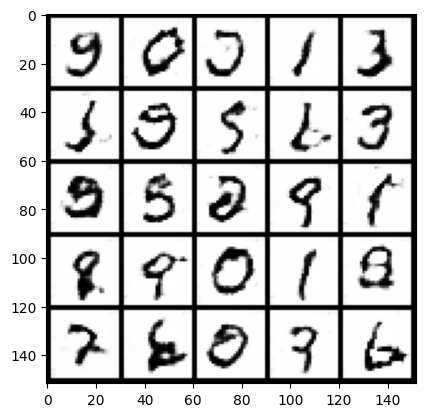

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, Generator loss: 0.7505, discriminator loss:  0.6858


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, Generator loss: 0.7447, discriminator loss:  0.6858


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, Generator loss: 0.7455, discriminator loss:  0.6869


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, Generator loss: 0.7360, discriminator loss:  0.6879


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, Generator loss: 0.7372, discriminator loss:  0.6892


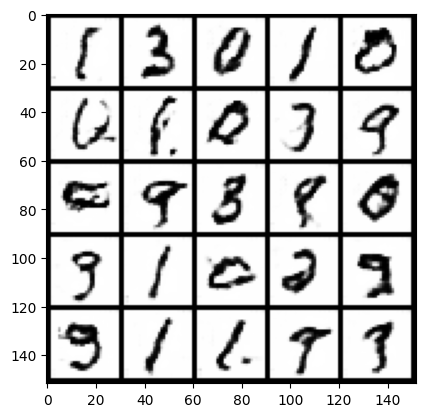

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, Generator loss: 0.7339, discriminator loss:  0.6919


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, Generator loss: 0.7228, discriminator loss:  0.6930


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, Generator loss: 0.7299, discriminator loss:  0.6930


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, Generator loss: 0.7267, discriminator loss:  0.6950


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, Generator loss: 0.7197, discriminator loss:  0.6928


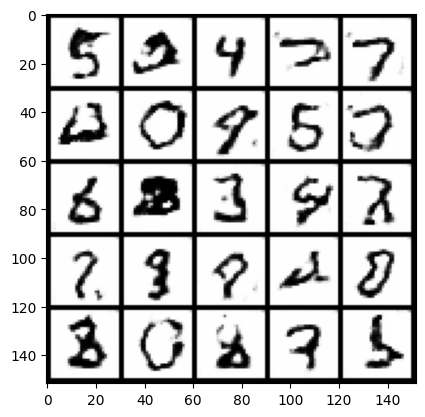

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16, Generator loss: 0.7190, discriminator loss:  0.6962


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, Generator loss: 0.7129, discriminator loss:  0.6939


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, Generator loss: 0.7290, discriminator loss:  0.6965


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, Generator loss: 0.7216, discriminator loss:  0.6947


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, Generator loss: 0.7161, discriminator loss:  0.6945


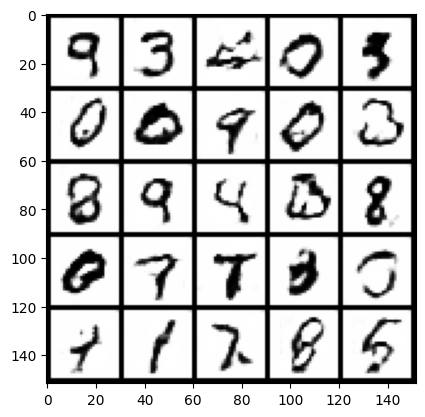

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, Generator loss: 0.7126, discriminator loss:  0.6930


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, Generator loss: 0.7180, discriminator loss:  0.6951


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, Generator loss: 0.7118, discriminator loss:  0.6949


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, Generator loss: 0.7080, discriminator loss:  0.6960


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, Generator loss: 0.7158, discriminator loss:  0.6947


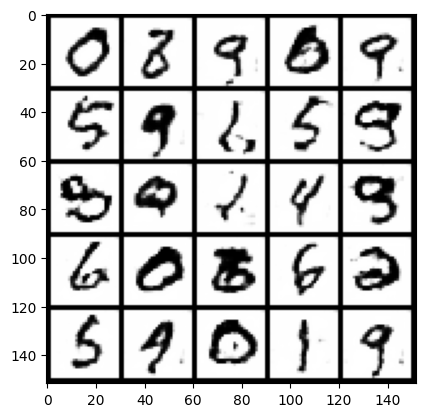

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, Generator loss: 0.7077, discriminator loss:  0.6948


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, Generator loss: 0.7092, discriminator loss:  0.6958


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, Generator loss: 0.7130, discriminator loss:  0.6945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, Generator loss: 0.7103, discriminator loss:  0.6941


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, Generator loss: 0.7083, discriminator loss:  0.6936


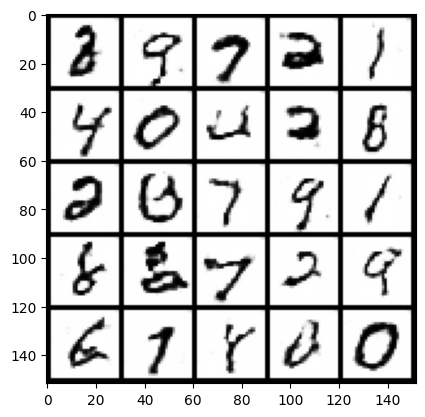

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, Generator loss: 0.7071, discriminator loss:  0.6945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32, Generator loss: 0.7083, discriminator loss:  0.6943


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, Generator loss: 0.7051, discriminator loss:  0.6941


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, Generator loss: 0.7071, discriminator loss:  0.6938


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, Generator loss: 0.7102, discriminator loss:  0.6950


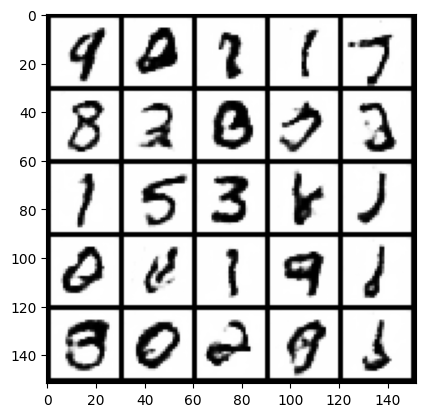

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, Generator loss: 0.7029, discriminator loss:  0.6940


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, Generator loss: 0.7046, discriminator loss:  0.6946


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, Generator loss: 0.7031, discriminator loss:  0.6943


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, Generator loss: 0.7034, discriminator loss:  0.6945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, Generator loss: 0.7043, discriminator loss:  0.6949


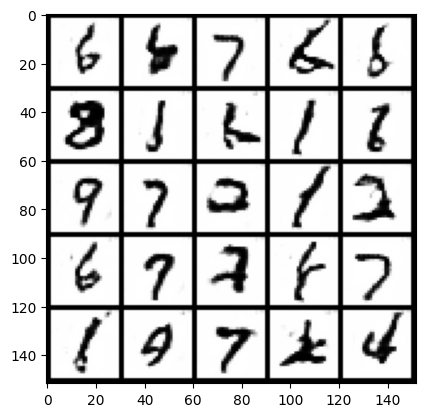

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, Generator loss: 0.7018, discriminator loss:  0.6946


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, Generator loss: 0.7013, discriminator loss:  0.6945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, Generator loss: 0.6997, discriminator loss:  0.6951


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, Generator loss: 0.7010, discriminator loss:  0.6943


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, Generator loss: 0.7008, discriminator loss:  0.6948


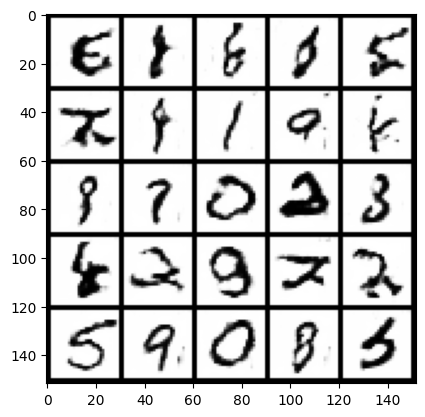

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, Generator loss: 0.6989, discriminator loss:  0.6949


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, Generator loss: 0.6994, discriminator loss:  0.6957


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48, Generator loss: 0.7002, discriminator loss:  0.6945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, Generator loss: 0.7008, discriminator loss:  0.6943


In [14]:
n_epochs = 50
mean_generator_loss = 0
mean_discriminator_loss = 0
generator_loss = []
discrininator_loss = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / len(dataloader)
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / len(dataloader)
    print(f"Epoch {epoch}, Generator loss: {mean_generator_loss:.4f}, discriminator loss: {mean_discriminator_loss: .4f}")
    generator_loss.append(mean_generator_loss)
    discrininator_loss.append(mean_discriminator_loss)
    ## Visualization code ##
    if epoch > 0 and epoch % 5 == 0:
        show_tensor_image(fake)

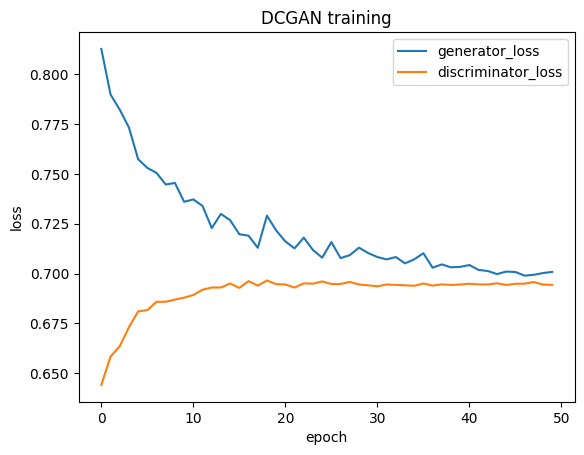

In [20]:
plt.plot(generator_loss)
plt.plot(discrininator_loss)
plt.title("DCGAN training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["generator_loss", "discriminator_loss"])
plt.show()